In [18]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats as stats


# Prepare loss function

In [19]:
def obstacle_penalty(observation, penalty_factor):
    """
    Calculates the value of probability density function of a bivariate normal distribution at a given point.
    Arguments:
    x, y : float
        Coordinates of the point at which to calculate the probability density value.
    mu_x, mu_y : float
        Mean values (expectations) along the X and Y axes, respectively.
    sigma_x, sigma_y : float
        Standard deviations along the X and Y axes, respectively.
    rho : float
        Correlation coefficient between X and Y.

    Returns:
    float
        Value of the probability density function of a bivariate normal distribution at the given point (x, y).
    """
    mu_x = obstacle_x = -0.5
    sigma_x = obstacle_sigma = 0.2

    mu_y = obstacle_y = -0.5
    sigma_y = obstacle_sigma = 0.2
    rho = 0
    x = observation[0]
    y = observation[1]
    z = ((x - mu_x) ** 2) / (sigma_x ** 2) + ((y - mu_y) ** 2) / (sigma_y ** 2) - (2 * rho * (x - mu_x) * (y - mu_y)) / (sigma_x * sigma_y)
    denom = 2 * np.pi * sigma_x * sigma_y * np.sqrt(1 - rho ** 2)
    return np.exp(-z / (2 * (1 - rho ** 2))) / denom * penalty_factor

In [20]:
x_lim = y_lim = [-1, 0]
X = np.arange(x_lim[0], x_lim[1], 0.01)
Y = np.arange(y_lim[0], y_lim[1], 0.01)

X, Y = np.meshgrid(X, Y)
Z = []
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z.append(obstacle_penalty(observation=[X[i, j], Y[i, j]], penalty_factor=1e1))

Z = np.array(Z).reshape((X.shape[0], X.shape[1]))
# len(Z)

In [21]:
linestyle_dict = {
     'loosely dotted': (0, (1, 10)),
     'dotted': (0, (1, 1)),
     'densely dotted': (0, (1, 1)),
     'long dash with offset': (5, (10, 3)),
     'loosely dashed': (0, (5, 10)),
     'dashed': (0, (5, 5)),
     'densely dashed': (0, (5, 1)),
     'loosely dashdotted': (0, (3, 10, 1, 10)),
     'dashdotted': (0, (3, 5, 1, 5)),
     'densely dashdotted': (0, (3, 1, 1, 1)),
     'dashdotdotted': (0, (3, 5, 1, 5, 1, 5)),
     'loosely dashdotdotted': (0, (3, 10, 1, 10, 1, 10)),
     'densely dashdotdotted': (0, (3, 1, 1, 1, 1, 1)),
     'solid': 'solid'
}
style = {
            1: "dotted", 
            5: "solid", 
            10: "dashed", 
            50: "dashdotted", 
            100: "loosely dashdotted"
        }

colors = {
            1: "tab:orange", 
            5: "tab:blue", 
            10: "tab:green", 
            50: "tab:red", 
            100: "tab:purple"
        }

# Get experiment information

## Load experiments

In [22]:
# data_dir = "regelum_data/outputs/2024-07-23/12-21-55/0/.callbacks/HistoricalDataCallback"
# data_dir = "regelum_data/outputs/2024-07-24/12-17-15/0/.callbacks/HistoricalDataCallback"
data_dir = "regelum_data/outputs/2024-07-25/13-36-48"
data_dir = "regelum_data/outputs/2024-07-25/15-34-05"
data_dir = "regelum_data/outputs/2024-08-01/10-03-43"

def get_df_from_folder(data_dir):
    df_list = []
    for root, dirs, files in os.walk(data_dir):
        if not root.endswith("HistoricalDataCallback"):
            continue

        for fn in files:
            if not fn.endswith(".h5"):
                continue

            file_path = os.path.join(root, fn)
            df = pd.read_hdf(file_path, key="data")
            df["file_name"] = fn
            df["seed"] = os.path.basename(os.path.dirname(os.path.dirname(root)))
            df["dis_2_goal"] = df.apply(lambda row: np.linalg.norm([row["x [m]"], row["y [m]"]]), axis=1)
            df_list.append(df)

    concat_df = pd.concat(df_list) if len(df_list) else pd.DataFrame()
    return concat_df

concat_df = get_df_from_folder(data_dir)
concat_df.head()

,time,running_objective,current_value,episode_id,iteration_id,velocity [m/s],angular velocity [rad/s],x [m],y [m],angle [rad],use_calf,critic_new,critic_safe,critic_low_kappa,critic_up_kappa,calf_diff,file_name,seed,dis_2_goal
0,0.0,0.306377,3.063771,1,1,0.22,-2.840000,-1.000000,-1.000000,3.141593,1,1.485454,310.201162,1.186960,11869.604401,-3.087157e+02,observations_actions_it_00001.h5,2,1.414214
1,0.1,0.597855,2.914779,1,1,-0.22,-2.840000,-1.021705,-0.996897,2.857593,0,1.485453,1.485454,1.020352,10203.521322,-9.424264e-07,observations_actions_it_00001.h5,2,1.427475
2,0.2,0.872605,2.747501,1,1,0.22,-1.974954,-1.001739,-1.005958,2.573593,1,0.895773,1.485454,0.863881,8638.810579,-5.896813e-01,observations_actions_it_00001.h5,2,1.419659
3,0.3,1.138008,2.654033,1,1,0.22,0.263327,-1.018999,-0.992374,2.376097,1,0.881306,0.895773,0.766900,7669.004161,-1.446689e-02,observations_actions_it_00001.h5,2,1.422380
4,0.4,1.404816,2.668076,1,1,-0.22,2.840000,-1.035061,-0.977341,2.402430,1,0.881222,0.881306,0.779822,7798.216356,-8.318842e-05,observations_actions_it_00001.h5,2,1.423568


## Get Nomial reference

In [23]:
ref_dir = "regelum_data/outputs/2024-07-25/11-15-03/0/.callbacks/HistoricalDataCallback"
ref_df = get_df_from_folder(ref_dir)
ref_df.head()

,time,running_objective,current_value,episode_id,iteration_id,velocity [m/s],angular velocity [rad/s],x [m],y [m],angle [rad],file_name,seed,dis_2_goal
0,0.0,0.306377,3.063771,1,1,-0.22,-2.84,-1.000000,-1.000000,3.141593,observations_actions_it_00001.h5,0,1.414214
1,0.1,0.593997,2.876197,1,1,-0.22,-2.84,-0.978295,-1.003103,2.857593,observations_actions_it_00001.h5,0,1.401170
2,0.2,0.865366,2.713693,1,1,-0.22,-2.84,-0.958328,-1.012164,2.573593,observations_actions_it_00001.h5,0,1.393868
3,0.3,1.122695,2.573287,1,1,0.22,-2.84,-0.941700,-1.026456,2.289593,observations_actions_it_00001.h5,0,1.392986
4,0.4,1.367541,2.448464,1,1,0.22,-2.84,-0.953657,-1.008077,2.005593,observations_actions_it_00001.h5,0,1.387689


# Plot validation images

In [24]:
concat_df.head()
concat_df["iteration_id"].max()

def filter_on_target_df(df):
    dis_2_goal_df = df.loc[:, ["seed", "iteration_id", "dis_2_goal"]].groupby(["seed", "iteration_id"]).agg("min")
    on_target_runs = dis_2_goal_df[dis_2_goal_df < 0.04].dropna().index
    on_target_records = df.apply(lambda row: (row["seed"], row["iteration_id"]) in on_target_runs, axis=1)
    return df[on_target_records]

clean_df = filter_on_target_df(concat_df)
clean_df.loc[:, ["seed", "iteration_id", "current_value"]].groupby(["seed", "iteration_id"]).agg("max").sort_values(by="current_value")

,,current_value
seed,iteration_id,
6,1,23.723125
8,1,30.097274
0,1,32.050622
7,1,32.126166
3,1,38.771395
2,1,38.824148
1,1,38.835277
9,1,39.549771
4,1,39.938847


In [25]:
def plot_trajectories_given_trajectory(df, ref_df=None):
    seeds =  df["seed"].unique()

    fig, ax = plt.subplots(sharey=True, figsize=(6, 6))

    cs = ax.contourf(X, Y, Z, alpha=1, levels=10, cmap="BuPu")
    cs.cmap.set_over('red')
    cs.cmap.set_under('blue')
    cs.changed()

    proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in cs.collections]


    for seed in seeds:
        sub_df_1 = df[df["seed"] == seed]
        trials = list(sub_df_1["file_name"].unique())
        trials.sort()

        for param_trial in trials:
            sub_df_2 = sub_df_1[sub_df_1["file_name"] == param_trial]
            alpha = (sub_df_2["iteration_id"].max()/sub_df_1["iteration_id"].max())

            ax.plot(sub_df_2["x [m]"], sub_df_2["y [m]"], 
                    linestyle=linestyle_dict[style[1]],
                    lw=1, 
                    color=colors[5] if sub_df_2["iteration_id"].max() <= sub_df_1["iteration_id"].max() - 1 else colors[50], 
                    alpha=alpha)
        
    if ref_df is not None:
        ax.plot(ref_df["x [m]"], ref_df["y [m]"], 
                linestyle=linestyle_dict[style[5]],
                lw=2, 
                color=colors[10], 
                alpha=1,
                label="Nominal")

    traj_legend = ax.legend()
    ax.legend(proxy, 
                 [f"{cs.levels[l_i-1]} - {cs.levels[l_i]}" for l_i in range(1, len(cs.levels))],
                 bbox_to_anchor=(1, 1))
    
    ax.add_artist(traj_legend)

    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    
    # Show the plot
    ax.grid(True)

    fig.savefig("media/trajectories.svg", dpi=fig.dpi)

# plot_trajectories_given_trajectory(concat_df)

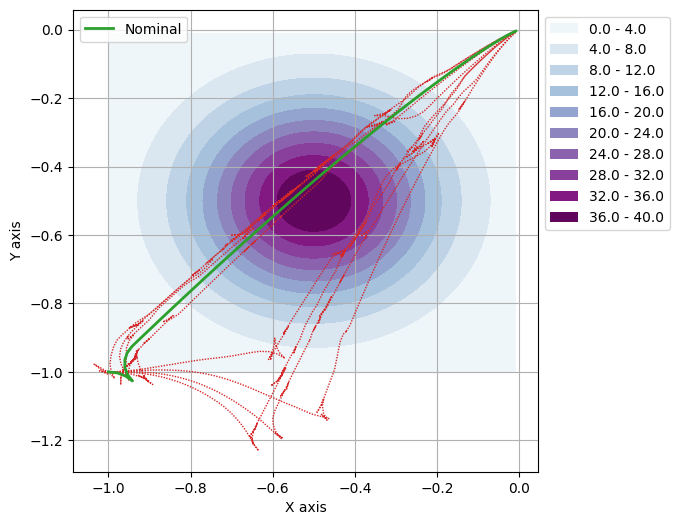

In [26]:
plot_trajectories_given_trajectory(clean_df, ref_df)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


('6', 1)

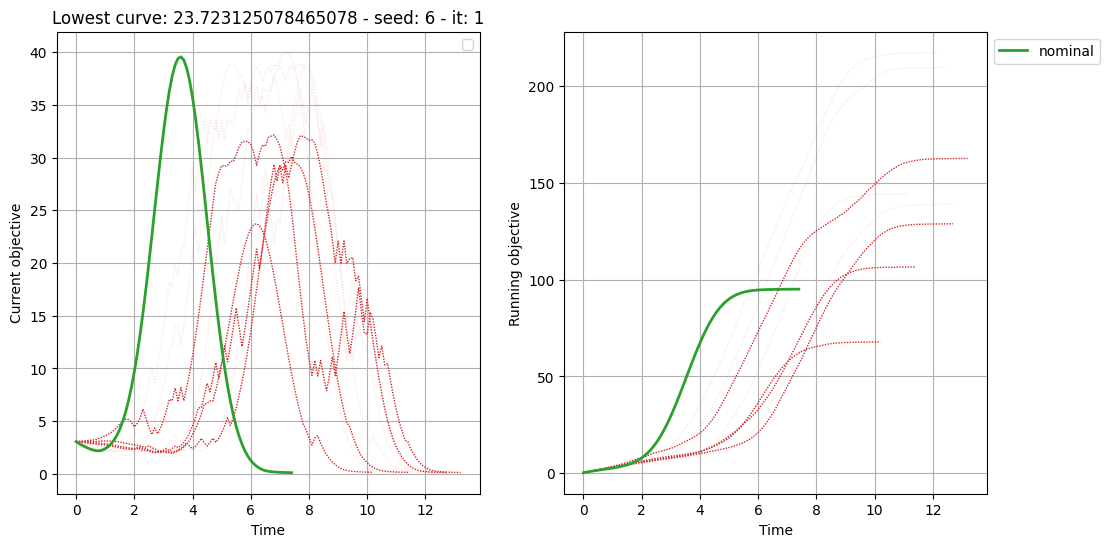

In [27]:
def plot_objective(df, ref_df=None):
    seeds = df["seed"].unique()
    lowest_current_value_runs = clean_df.loc[:, ["seed", "iteration_id", "current_value"]].groupby(["seed", "iteration_id"]).agg("max").sort_values(by="current_value")
    lowest_current_value = lowest_current_value_runs.values[0, 0]
    lowest_current_value_info = lowest_current_value_runs.index[0]

    fig, ax = plt.subplots(1,2,sharey=False, figsize=(12, 6))

    for seed in seeds:
        sub_df_1 = df[df["seed"] == seed]
        trials = list(sub_df_1["file_name"].unique())
        trials.sort()

        for param_trial in trials:
            sub_df_2 = sub_df_1[sub_df_1["file_name"] == param_trial]
            # alpha = (sub_df_2["current_value"].max()/sub_df_1["current_value"].max())
            lowest_current_value
            rv = stats.norm(loc=lowest_current_value, scale=5)
            alpha = rv.pdf(sub_df_2["current_value"].max())*100
            alpha = np.clip(alpha, 0.1, 1)

            ax[0].plot(sub_df_2["time"], sub_df_2["current_value"], 
                    linestyle=linestyle_dict[style[1]],
                    lw=1, 
                    color=colors[5] if sub_df_2["iteration_id"].max() <= sub_df_1["iteration_id"].max() - 5 else colors[50], 
                    alpha=alpha)
            
            ax[1].plot(sub_df_2["time"], sub_df_2["running_objective"], 
                    linestyle=linestyle_dict[style[1]],
                    lw=1, 
                    color=colors[5] if sub_df_2["iteration_id"].max() <= sub_df_1["iteration_id"].max() - 5 else colors[50], 
                    alpha=alpha)
        
    if ref_df is not None:
        ax[0].plot(ref_df["time"], ref_df["current_value"], 
                linestyle=linestyle_dict[style[5]],
                lw=2, 
                color=colors[10], 
                alpha=1)
        
        ax[1].plot(ref_df["time"], ref_df["running_objective"], 
                linestyle=linestyle_dict[style[5]],
                lw=2, 
                color=colors[10], 
                alpha=1,
                label="nominal")

    ax[0].set_title("Lowest curve: {} - seed: {} - it: {}".format(lowest_current_value, lowest_current_value_info[0], lowest_current_value_info[1]))
    # draw goal pose
    ax[0].legend(bbox_to_anchor=(1, 1))
    ax[1].legend(bbox_to_anchor=(1, 1))

    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('Current objective')
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('Running objective')
    
    # Show the plot
    ax[0].grid(True)
    ax[1].grid(True)

    fig.savefig("media/objectives.svg", dpi=fig.dpi)


plot_objective(clean_df, ref_df)

# concat_df.loc["iteration_id"]
# clean_df.loc[:, ["seed", "iteration_id", "current_value"]].groupby(["seed", "iteration_id"]).agg("max").sort_values(by="current_value").values[0, 0]
clean_df.loc[:, ["seed", "iteration_id", "current_value"]].groupby(["seed", "iteration_id"]).agg("max").sort_values(by="current_value").index[0]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


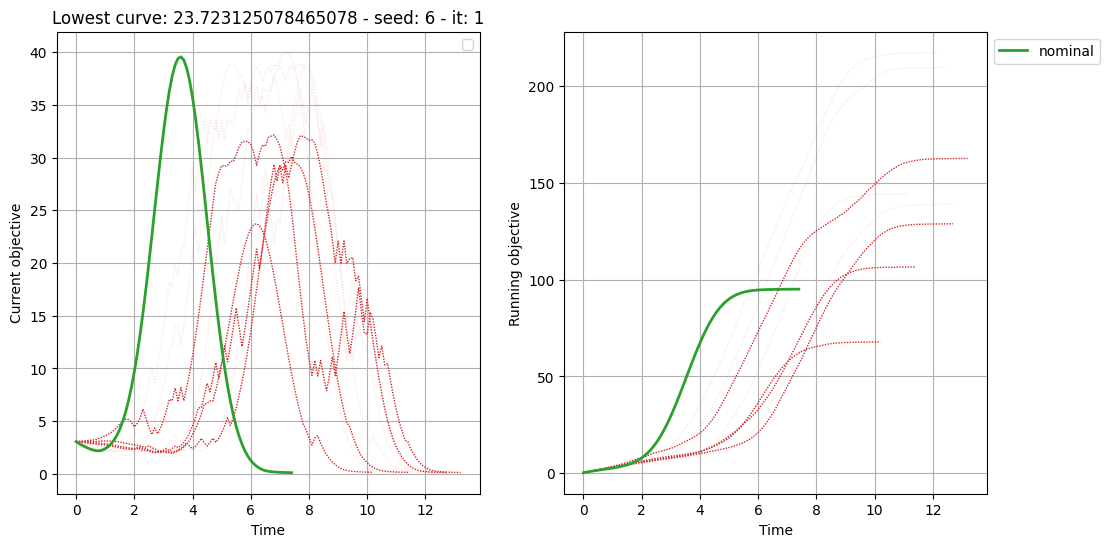

In [28]:
plot_objective(clean_df, ref_df)

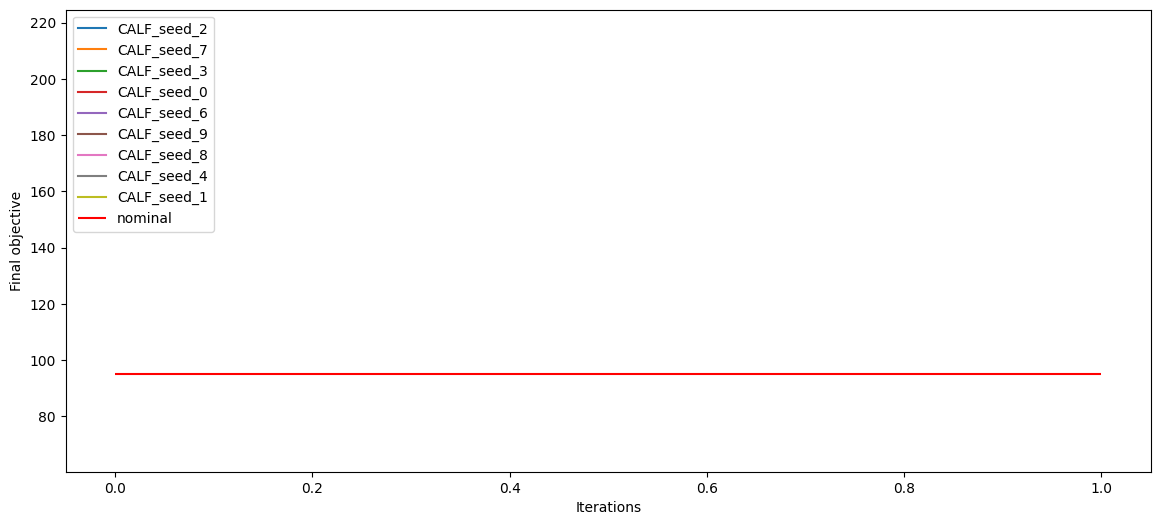

In [29]:
def plot_final_cost(df):
    fig, ax = plt.subplots(figsize=(14, 6))

    seeds = df["seed"].unique()
    for seed in seeds:
        sub_df_1 = df[df["seed"] == seed]
        sub_df_1.groupby("iteration_id")["running_objective"].max().plot(ax=ax, label=f"CALF_seed_{seed}")

    ax.hlines(ref_df["running_objective"].max(), 
            xmin=0, 
            xmax=df["iteration_id"].max(), 
            colors="red",
            label="nominal")

    ax.legend()
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Final objective')

plot_final_cost(clean_df)

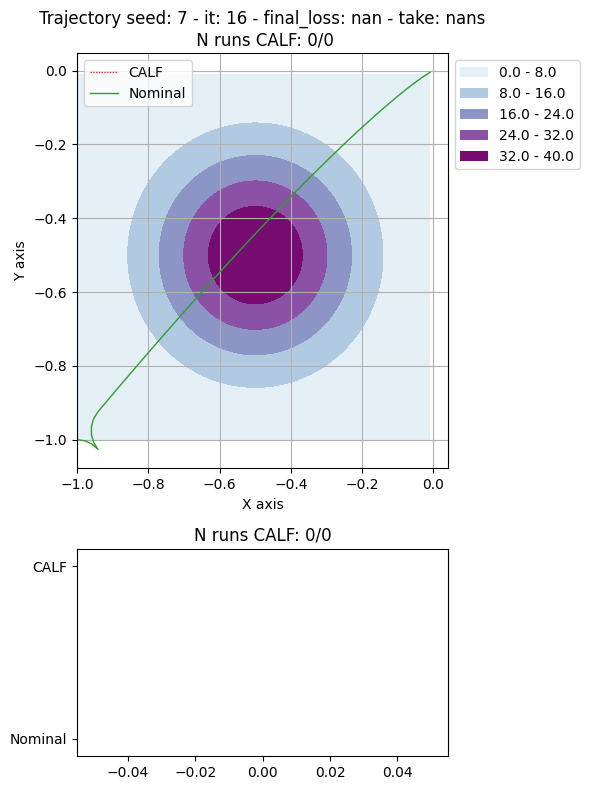

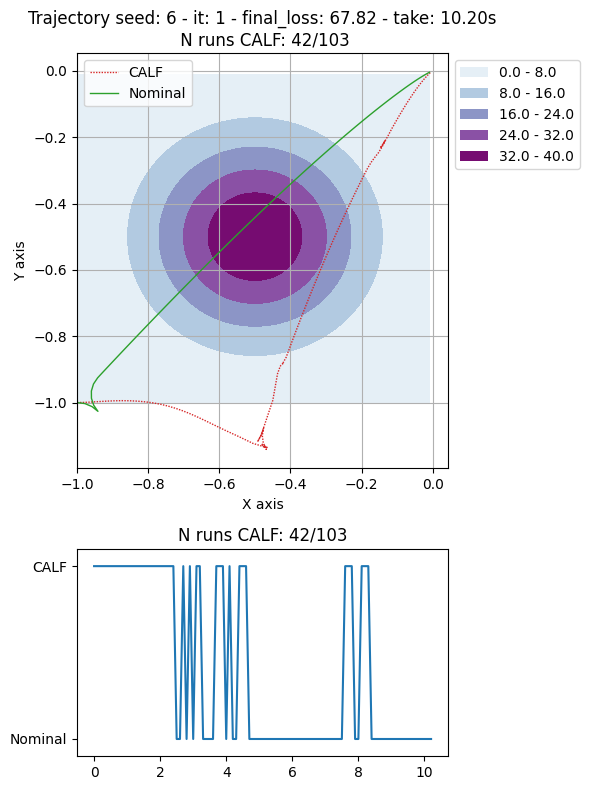

In [30]:
def plot_chosen_trajectory(df, it, seed=0, ref_df=None):
    fig, ax = plt.subplots(2, 1, sharey=False, figsize=(6, 8), height_ratios=[2, 1])

    cs = ax[0].contourf(X, Y, Z, alpha=1, levels=5, cmap="BuPu")
    cs.cmap.set_over('red')
    cs.cmap.set_under('blue')
    cs.changed()

    proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in cs.collections]

    sub_df_1 = df[df["seed"] == str(seed)]
    sub_df_2 = sub_df_1[sub_df_1["iteration_id"] == it]
    ax[0].plot(sub_df_2["x [m]"], sub_df_2["y [m]"], 
            linestyle=linestyle_dict[style[1]],
            lw=1, 
            color=colors[5] if sub_df_2["iteration_id"].max() <= sub_df_1["iteration_id"].max() - 5 else colors[50], 
            alpha=1,
            label="CALF")

    ax[0].set_title("Trajectory seed: {} - it: {} - final_loss: {:.2f} - take: {:.2f}s\n N runs CALF: {}/{}".format(
                    seed, 
                    it, 
                    sub_df_2["running_objective"].max(), 
                    sub_df_2["time"].max(),
                    sub_df_2["use_calf"].sum(),
                    sub_df_2["use_calf"].count()))
    
    ax[1].plot(sub_df_2["time"], sub_df_2["use_calf"])
    ax[1].set_ylim([-0.1, 1.1])
    ax[1].set_yticks([0, 1], ["Nominal", "CALF"])
    ax[1].set_title("N runs CALF: {}/{}".format(
        sub_df_2["use_calf"].sum(),
        sub_df_2["use_calf"].count()
    ))

    if ref_df is not None:
        ax[0].plot(ref_df["x [m]"], ref_df["y [m]"], 
                linestyle=linestyle_dict[style[5]],
                lw=1, 
                color=colors[10], 
                alpha=1,
                label="Nominal")

    traj_legend = ax[0].legend()
    ax[0].legend(proxy, 
                 [f"{cs.levels[l_i-1]} - {cs.levels[l_i]}" for l_i in range(1, len(cs.levels))],
                 bbox_to_anchor=(1, 1))

    ax[0].set_xlabel('X axis')
    ax[0].set_ylabel('Y axis')
    
    ax[0].add_artist(traj_legend)
    # Show the plot
    ax[0].grid(True)
    plt.tight_layout()
    fig.savefig("media/trajectories_with_ref.svg", dpi=fig.dpi)

plot_chosen_trajectory(clean_df, ref_df=ref_df, it=16, seed=7)
plot_chosen_trajectory(clean_df, ref_df=ref_df, it=1, seed=6)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


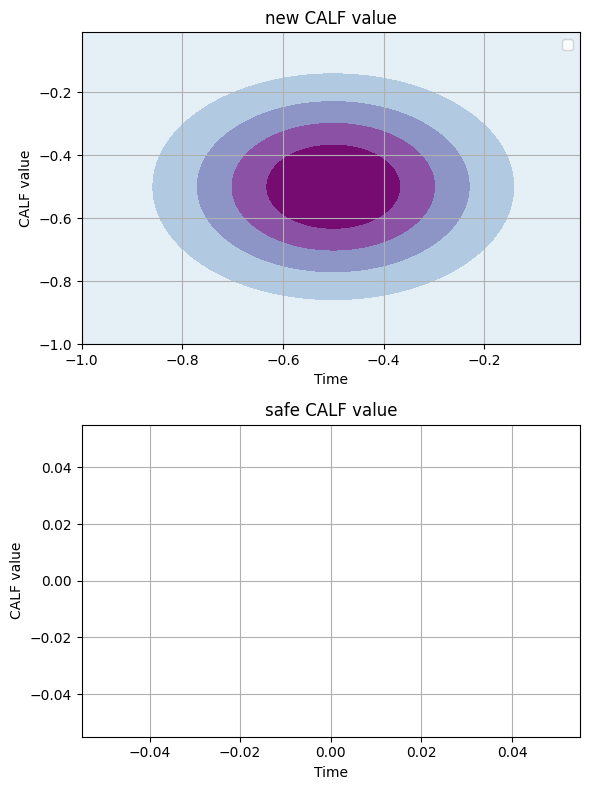

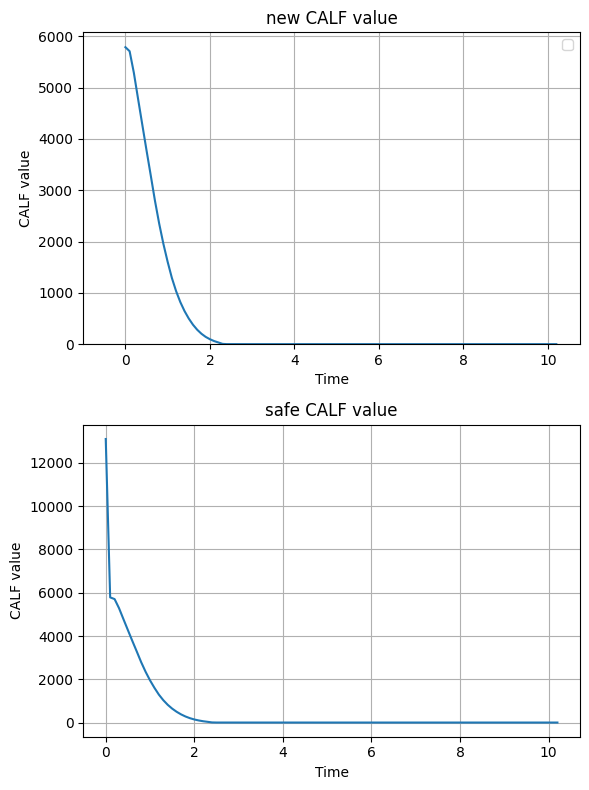

In [31]:
def plot_chosen_calf_value(df, it, seed=0):
    fig, ax = plt.subplots(2, 1, sharey=False, figsize=(6, 8), height_ratios=[1, 1])

    cs = ax[0].contourf(X, Y, Z, alpha=1, levels=5, cmap="BuPu")
    cs.cmap.set_over('red')
    cs.cmap.set_under('blue')
    cs.changed()

    proxy = [plt.Rectangle((0,0),1,1,fc = pc.get_facecolor()[0]) for pc in cs.collections]

    sub_df_1 = df[df["seed"] == str(seed)]
    sub_df_2 = sub_df_1[sub_df_1["iteration_id"] == it]
    ax[0].plot(sub_df_2["time"], sub_df_2["critic_new"])
    ax[0].set_title("new CALF value")
    
    ax[1].plot(sub_df_2["time"], sub_df_2["critic_safe"], label="safe CALF value")
    ax[1].set_title("safe CALF value")

    ax[0].legend()
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('CALF value')
    ax[0].grid(True)

    ax[1].grid(True)
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('CALF value')
    plt.tight_layout()
    fig.savefig("media/CALF_value.svg", dpi=fig.dpi)

plot_chosen_calf_value(concat_df, it=16, seed=7)
plot_chosen_calf_value(concat_df, it=1, seed=6)

# Choose best runs

In [32]:
# concat_df.loc[:, ["seed", "iteration_id", "current_value", "dis_2_goal"]].groupby(["seed", "iteration_id"]).agg("max").sort_values(by="current_value").head(10)

filter_on_target_df(concat_df)

,time,running_objective,current_value,episode_id,iteration_id,velocity [m/s],angular velocity [rad/s],x [m],y [m],angle [rad],use_calf,critic_new,critic_safe,critic_low_kappa,critic_up_kappa,calf_diff,file_name,seed,dis_2_goal
0,0.0,0.306377,3.063771,1,1,0.220000,-2.840000,-1.000000,-1.000000,3.141593,1,1.485454,310.201162,1.186960,11869.604401,-3.087157e+02,observations_actions_it_00001.h5,2,1.414214
1,0.1,0.597855,2.914779,1,1,-0.220000,-2.840000,-1.021705,-0.996897,2.857593,0,1.485453,1.485454,1.020352,10203.521322,-9.424264e-07,observations_actions_it_00001.h5,2,1.427475
2,0.2,0.872605,2.747501,1,1,0.220000,-1.974954,-1.001739,-1.005958,2.573593,1,0.895773,1.485454,0.863881,8638.810579,-5.896813e-01,observations_actions_it_00001.h5,2,1.419659
3,0.3,1.138008,2.654033,1,1,0.220000,0.263327,-1.018999,-0.992374,2.376097,1,0.881306,0.895773,0.766900,7669.004161,-1.446689e-02,observations_actions_it_00001.h5,2,1.422380
4,0.4,1.404816,2.668076,1,1,-0.220000,2.840000,-1.035061,-0.977341,2.402430,1,0.881222,0.881306,0.779822,7798.216356,-8.318842e-05,observations_actions_it_00001.h5,2,1.423568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,12.1,209.497303,0.149643,1,1,0.039426,-0.169245,-0.016519,-0.010757,0.646224,0,0.023576,0.018292,0.041799,417.994678,5.284206e-03,observations_actions_it_00001.h5,1,0.019713
122,12.2,209.511339,0.140360,1,1,0.031559,-0.164827,-0.013352,-0.008410,0.629300,0,0.018471,0.018292,0.039627,396.267456,1.796327e-04,observations_actions_it_00001.h5,1,0.015779
123,12.3,209.524634,0.132947,1,1,0.025261,-0.160518,-0.010785,-0.006574,0.612817,0,0.037260,0.018292,0.037570,375.704594,1.896811e-02,observations_actions_it_00001.h5,1,0.012630
124,12.4,209.537326,0.126921,1,1,0.020219,-0.156323,-0.008707,-0.005137,0.596766,0,0.033906,0.018292,0.035623,356.231293,1.561400e-02,observations_actions_it_00001.h5,1,0.010110


In [33]:
import numpy as np

file_path = "regelum_data/outputs/2024-07-25/15-34-05/5/.callbacks/PolicyNumpyModelSaver/model_it_00008.npy"
np.load(file_path)

array([[840.77299884,  57.15768448,  69.26495025, 343.54587708,
        442.21957115, 615.59968761, 116.39389034, 205.24973822,
        225.25329311, 305.34649108, 753.57204667]])